<a href="https://colab.research.google.com/github/SCVFlare/Twitter-Spammer-Detection/blob/main/Spammer_detection_Twitter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spammer detection-Twitter - Boyan BECHEV, Jules JEHANNO


## **Préparation**

### Imports

In [1]:
pip install scikit-plot

In [2]:
import pandas as pd
import numpy as np
import re, string
from scipy.stats import zscore
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import scikitplot as skplt
import matplotlib.pyplot as plt

### Collection des données



> Connexion au web et téléchargement de data "Social Honeypot"



In [3]:
!wget http://infolab.tamu.edu/data/social_honeypot_icwsm_2011.zip

--2021-09-22 14:41:59--  http://infolab.tamu.edu/data/social_honeypot_icwsm_2011.zip
Resolving infolab.tamu.edu (infolab.tamu.edu)... 45.55.217.29
Connecting to infolab.tamu.edu (infolab.tamu.edu)|45.55.217.29|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 263659672 (251M) [application/zip]
Saving to: ‘social_honeypot_icwsm_2011.zip’

social_honeypot_icw 100%[===================>] 251.45M   204MB/s    in 1.2s    

2021-09-22 14:42:00 (204 MB/s) - ‘social_honeypot_icwsm_2011.zip’ saved [263659672/263659672]






> Désarchiver l'archive





In [4]:
!unzip social_honeypot_icwsm_2011.zip

Archive:  social_honeypot_icwsm_2011.zip
   creating: social_honeypot_icwsm_2011/
  inflating: social_honeypot_icwsm_2011/content_polluters.txt  
   creating: __MACOSX/
   creating: __MACOSX/social_honeypot_icwsm_2011/
  inflating: __MACOSX/social_honeypot_icwsm_2011/._content_polluters.txt  
  inflating: social_honeypot_icwsm_2011/content_polluters_followings.txt  
  inflating: __MACOSX/social_honeypot_icwsm_2011/._content_polluters_followings.txt  
  inflating: social_honeypot_icwsm_2011/content_polluters_tweets.txt  
  inflating: __MACOSX/social_honeypot_icwsm_2011/._content_polluters_tweets.txt  
  inflating: social_honeypot_icwsm_2011/legitimate_users.txt  
  inflating: __MACOSX/social_honeypot_icwsm_2011/._legitimate_users.txt  
  inflating: social_honeypot_icwsm_2011/legitimate_users_followings.txt  
  inflating: __MACOSX/social_honeypot_icwsm_2011/._legitimate_users_followings.txt  
  inflating: social_honeypot_icwsm_2011/legitimate_users_tweets.txt  
  inflating: __MACOSX/soci

### Analyse des fichiers



> Convertir tous les fichiers text en Panda DataFrame. À chaque colonne est approprié un bon type pour faciliter le traitement
 


In [5]:

def func(string):
   return pd.Series(string.split(',')).astype(int)
  
  
dfContent_polluters = pd.read_csv('social_honeypot_icwsm_2011/content_polluters.txt',sep='\t', names=
                 ["UserID","CreatedAt","CollectedAt","NumberOfFollowings","NumberOfFollowers",
                  "NumberOfTweets","LengthOfScreenName","LengthOfDescriptionInUserProfile"],
                parse_dates=["CreatedAt","CollectedAt"],index_col=0)

dfContent_polluters_followings = pd.read_csv('social_honeypot_icwsm_2011/content_polluters_followings.txt',sep='\t', names=
                 ["UserID","SeriesOfNumberOfFollowings"],converters={"SeriesOfNumberOfFollowings":func},index_col=0)

dfContent_polluters_tweets = pd.read_csv('social_honeypot_icwsm_2011/content_polluters_tweets.txt',sep='\t', names=
                 ["UserID","TweetID","Tweet","CreatedAt"], parse_dates=["CreatedAt"],index_col=0)


dfLegitimate_users = pd.read_csv('social_honeypot_icwsm_2011/legitimate_users.txt',sep='\t', names=
                 ["UserID","CreatedAt","CollectedAt","NumberOfFollowings","NumberOfFollowers",
                  "NumberOfTweets","LengthOfScreenName","LengthOfDescriptionInUserProfile"],
                parse_dates=["CreatedAt","CollectedAt"],index_col=0)

dfLegitimate_users_followings = pd.read_csv('social_honeypot_icwsm_2011/legitimate_users_followings.txt',sep='\t', names=
                 ["UserID","SeriesOfNumberOfFollowings"],converters={"SeriesOfNumberOfFollowings":func},index_col=0)


dfLegitimate_users_tweets = pd.read_csv('social_honeypot_icwsm_2011/legitimate_users_tweets.txt',sep='\t', names=
                 ["UserID","TweetID","Tweet","CreatedAt"], parse_dates=["CreatedAt"],index_col=0)


/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


## 	**Calcul	des	caractéristiques**

### 1 - The length of the screen name

In [6]:
def lengthName(data_frame) :
  df = pd.DataFrame({"LengthOfScreenName":data_frame["LengthOfScreenName"]})
  return df

### 2 - The length of the description

In [7]:
def lengthDes(data_frame) :
  df = pd.DataFrame({"LengthOfDescription":data_frame["LengthOfDescriptionInUserProfile"]})
  return df

### 3 - The	longevity	of	the	account

In [8]:

def longevity(data_frame) :
  df=pd.DataFrame({"LongevityOfAccount": (data_frame["CollectedAt"]-data_frame["CreatedAt"])/np.timedelta64(1, 'D')})
  return df

### 4 - Numbers of followings

In [9]:
def nbrFollowings(data_frame) :
  df = pd.DataFrame({"NumberOfFollowings":data_frame["NumberOfFollowings"]})
  return df

### 5 - Numbers of followers

In [10]:
def nbrFollowers(data_frame) :
  df = pd.DataFrame({"NumberOfFollowers":data_frame["NumberOfFollowers"]})
  return df

### 6 - The standard	deviation	of unique	numerical	IDs	of following

In [11]:
def std(x):
  return x.std()

def followingsSTD(data_frame) :
  df = pd.DataFrame({"STDOfUniqueFollowers":data_frame["SeriesOfNumberOfFollowings"].apply(std)})
  return df

### 7 - Followings / Followers

In [12]:
def quotientFF(data_frame) :
  df = pd.DataFrame({"RatioFollowings/Followers": (data_frame["NumberOfFollowings"] / data_frame["NumberOfFollowers"]) })
  return df 

### 8 - Number of tweets

In [13]:

def nbrOfTweets(data_frame) :
  df = pd.DataFrame({"NumberOfTweets": data_frame["NumberOfTweets"] })
  return df

### 9 - Number of tweets / day

In [14]:


def numberOfTweetsPerDay(data_frame) :
  dftemp = pd.DataFrame({"CreatedAt":data_frame["CreatedAt"].dt.date})
  query=dftemp.groupby(["UserID","CreatedAt"]).size()
  query2=query.groupby(["UserID"]).mean().reset_index(name='0')
  df = pd.DataFrame({"UserID":query2["UserID"],"NumberOfTweetsPerDay":query2["0"]})
  df=df.set_index("UserID")
  return df


### 10 - |Tweets| / longevity

In [15]:
def avgOfTweetsPerAcc(data_frame) :
  df = pd.DataFrame({"RatioTweets/Account": nbrOfTweets(data_frame)["NumberOfTweets"]/longevity(data_frame)["LongevityOfAccount"] })
  return df

### 11 - |Tweets with URL|  /  |Tweets|

In [16]:
def existURL(tweet) :
  if(len(re.findall('https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+', str(tweet)))==0):
    return 0;
  else:
    return 1;
  
def URLsPerTweets(data_frame) :
  dftemp=pd.DataFrame({"AvgTweetsWithURL": data_frame["Tweet"].apply(existURL)})
  df = dftemp.groupby(["UserID"]).mean()
  return df


### 12 - Average URLs / Tweet

In [17]:
def URLcount(tweet):
  return len(re.findall('https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+', str(tweet)))

def averageURL(data_frame) :
  dftemp=pd.DataFrame({"RatioURL/Tweet": data_frame["Tweet"].apply(URLcount)})
  df = dftemp.groupby(["UserID"]).mean()
  return df

### 13 - Average mentions / Tweet

In [18]:
def countM(tweet):
  return len(re.findall('\s([@#][\w_-]+)', str(tweet)))

def mentionsPerTweets(data_frame):
  dftemp=pd.DataFrame({"AvgMentionsPerTweet": data_frame["Tweet"].apply(countM)})
  df = dftemp.groupby(["UserID"]).mean()
  return df

### 14 - Average time between 2 consecutives tweets

In [19]:
def avgTimeBetween2Tweets(data_frame):
  temp=pd.DataFrame({"CreatedAt":data_frame["CreatedAt"]}).sort_values(by=['UserID','CreatedAt'])
  dftemp=pd.DataFrame({"PreviousTweet":temp.groupby(['UserID']).apply(lambda x:x)['CreatedAt'],
                       "NextTweet":temp.groupby(['UserID']).shift(-1)['CreatedAt']})
  df=pd.DataFrame({"AvgMinutesBetween2Tweets": (dftemp["NextTweet"]-dftemp["PreviousTweet"]) / np.timedelta64(1, 'm')})
  df=df.groupby(["UserID"]).mean()
  return df

### 15 - Max time between 2 consecutives tweets

In [20]:
def maxTimeBetween2Tweets(data_frame):
  temp=pd.DataFrame({"CreatedAt":data_frame["CreatedAt"]}).sort_values(by=['UserID','CreatedAt'])
  dftemp=pd.DataFrame({"PreviousTweet":temp.groupby(['UserID']).apply(lambda x:x)['CreatedAt'],
                       "NextTweet":temp.groupby(['UserID']).shift(-1)['CreatedAt']})
  df=pd.DataFrame({"MaxTimeBetween2Tweets": (dftemp["NextTweet"]-dftemp["PreviousTweet"]) / np.timedelta64(1, 'm')})
  df=df.groupby(["UserID"]).max()
  return df

## **Prétraitement**

### Fusion des caractéristiques



**Concatenation des caractéristiques 1-8 et 10 car ils ont été extrait par le fichier géneral d'utilisateurs**



In [21]:
first_features_polluters=pd.concat([lengthName(dfContent_polluters),lengthDes(dfContent_polluters),
                           longevity(dfContent_polluters),nbrFollowings(dfContent_polluters),nbrFollowers(dfContent_polluters),
                        followingsSTD(dfContent_polluters_followings),quotientFF(dfContent_polluters),
                        nbrOfTweets(dfContent_polluters),avgOfTweetsPerAcc(dfContent_polluters)],axis=1)

first_features_legitimate=pd.concat([lengthName(dfLegitimate_users),lengthDes(dfLegitimate_users),
                           longevity(dfLegitimate_users),nbrFollowings(dfLegitimate_users),nbrFollowers(dfLegitimate_users),
                        followingsSTD(dfLegitimate_users_followings),quotientFF(dfLegitimate_users),
                        nbrOfTweets(dfLegitimate_users),avgOfTweetsPerAcc(dfLegitimate_users)],axis=1)



**Concatenation des caractéristiques 11-15 et 9 car ils ont été extrait par le fichier de tweets**



In [22]:
second_features_polluters=pd.concat([numberOfTweetsPerDay(dfContent_polluters_tweets),URLsPerTweets(dfContent_polluters_tweets),
                                     averageURL(dfContent_polluters_tweets),mentionsPerTweets(dfContent_polluters_tweets),
                                     avgTimeBetween2Tweets(dfContent_polluters_tweets),maxTimeBetween2Tweets(dfContent_polluters_tweets)],axis=1)

second_features_legitimate=pd.concat([numberOfTweetsPerDay(dfLegitimate_users_tweets),URLsPerTweets(dfLegitimate_users_tweets),
                                     averageURL(dfLegitimate_users_tweets),mentionsPerTweets(dfLegitimate_users_tweets),
                                     avgTimeBetween2Tweets(dfLegitimate_users_tweets),maxTimeBetween2Tweets(dfLegitimate_users_tweets)],axis=1)



**Fusion des caractéristiques par rapport au "UserID" comme index**





In [23]:
data_set_polluters = first_features_polluters.join(second_features_polluters,how="inner")

data_set_legitimate = first_features_legitimate.join(second_features_legitimate,how="inner")



**Ajout de classe 1 pour "polluters" et 0 "legitimate"**



In [24]:
data_set_polluters.insert(0,"Class",1)
data_set_legitimate.insert(0,"Class",0)


**Fusion des 2 data sets**



In [25]:
data_set=pd.concat([data_set_polluters,data_set_legitimate])

### Nettoyage de DataSet



**Vérification	et	suppression	des	attributs	à	valeur	unique.**



In [26]:
def attributesOfUniqueValues(dataset) :
  list=[]
  for col in dataset.columns:
    if (dataset[col]==dataset[col].iloc[0]).all == True:
      list.append(col)
  return data_set.drop(list)



> Ils n'existent pas






**Suppression	des	instances	de	données	en	double.**



In [27]:
def duplicateRows(dataset):
  return data_set.drop_duplicates()



> Ils n'existent pas





**Remplacement	des	valeurs	manquantes	(remplacé par	0).**



In [28]:
def missingValues(dataset):
  valuesReplaced = dataset.replace([np.inf,-np.inf],np.nan)
  valuesReplaced.fillna(0,inplace=True)
  return valuesReplaced

Des valuers manquant appraissent dans:

> L'attribut "Ratio Followings/Followers" a cause des utilisateurs qui n'ont pas des followers.


> L'attribut "AvgMinutesBetween2Tweets" a cause de dernier tweet d'un utilisateur qui n'a pas une prochaine tweet


> L'attribut "MaxTimeBetween2Tweets" a cause de dernier tweet d'un utilisateur qui n'a pas une prochaine tweet








**Normalisation	des	données	(approche	z-score).**



In [29]:
def zscores(dataset):
  df=data_set.drop(["Class"],axis=1)
  df=df.apply(zscore)
  df["Class"]=dataset["Class"]
  return df

### Résultat Finale

**Application de Nettoyage**

In [30]:
data_set=attributesOfUniqueValues(data_set)
data_set=duplicateRows(data_set)
data_set=missingValues(data_set)
data_set=zscores(data_set)

**Fichier CSV**

In [31]:
export_csv = data_set.to_csv (r'data_set.csv', index = None, header=True)

## 	**Analyse	comparative**

### Application des algorithmes



**Préparation des données de test et d'entrainement**



In [32]:
X=data_set.drop(['Class'],axis=1)
X=X.values
Y=data_set["Class"].values
train, test, target, trueResult = train_test_split(X, Y, test_size=0.3, random_state=1)

**Application des Algorithmes**

In [33]:

# Decision Tree
decisionTree = DecisionTreeClassifier(random_state=0)
decisionTree.fit(train, target)
predictedAD = decisionTree.predict(test)
probasAD = decisionTree.predict_proba(test)

# Random Forest
randomForest = RandomForestClassifier(n_estimators=100)
randomForest.fit(train, target)
predictedRF = randomForest.predict(test)
probasRF = randomForest.predict_proba(test)

# Naive Bayes
gnb = GaussianNB()
gnb.fit(train, target)
predictedNB = gnb.predict(test)
probasNB = gnb.predict_proba(test)


### Performances



> Arbre de décision



Precision: 0.9202
Recall: 0.9051
F-mesure: 0.9126
Surface sous la courbe ROC: 0.9101


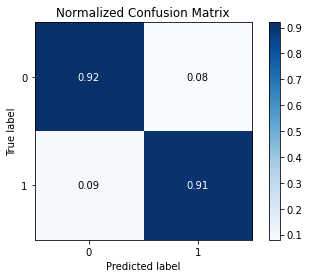

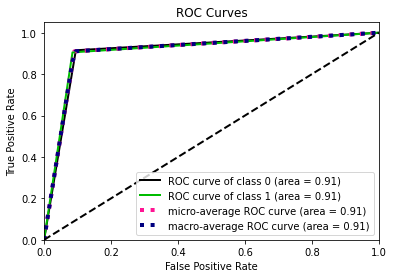

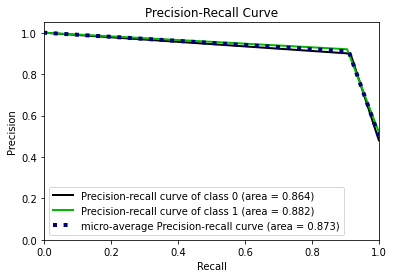

In [34]:
precisionAD = precision_score(trueResult, predictedAD)
recallAD = recall_score(trueResult, predictedAD)
fmeasureAD = f1_score(trueResult, predictedAD)
fprAD, tprAD, thresholdsAD = roc_curve(trueResult, predictedAD)
rocAD = metrics.auc(fprAD, tprAD)
print("Precision: %0.4f" % precisionAD)
print("Recall: %0.4f" % recallAD)
print("F-mesure: %0.4f" % fmeasureAD)
print("Surface sous la courbe ROC: %0.4f" % rocAD)
skplt.metrics.plot_confusion_matrix(trueResult, predictedAD, normalize=True)
skplt.metrics.plot_roc(trueResult, probasAD)
skplt.metrics.plot_precision_recall(trueResult, probasAD)




> Random Forest



Precision: 0.9442
Recall: 0.9516
F-mesure: 0.9479
Surface sous la courbe ROC: 0.9454


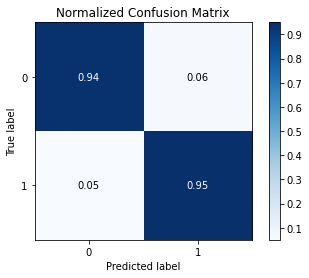

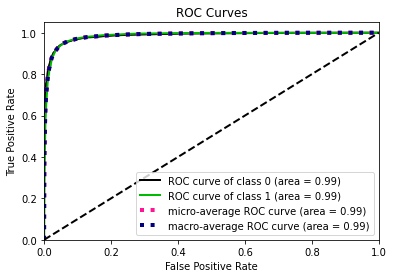

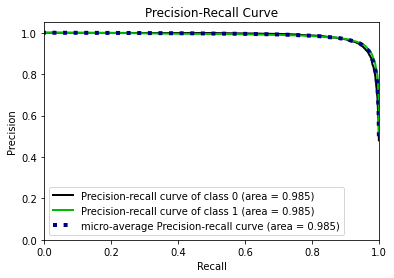

In [35]:
precisionRF = precision_score(trueResult, predictedRF)
recallRF = recall_score(trueResult, predictedRF)
fmeasureRF = f1_score(trueResult, predictedRF)
fprRF, tprRF, thresholdsRF = roc_curve(trueResult, predictedRF)
rocRF = metrics.auc(fprRF, tprRF)
print("Precision: %0.4f" % precisionRF)
print("Recall: %0.4f" % recallRF)
print("F-mesure: %0.4f" % fmeasureRF)
print("Surface sous la courbe ROC: %0.4f" % rocRF)
skplt.metrics.plot_confusion_matrix(trueResult, predictedRF, normalize=True)
skplt.metrics.plot_roc(trueResult, probasRF)
skplt.metrics.plot_precision_recall(trueResult, probasRF)



>Classification bayésienne naïve



Precision: 0.9478
Recall: 0.2744
F-mesure: 0.4256
Surface sous la courbe ROC: 0.6290


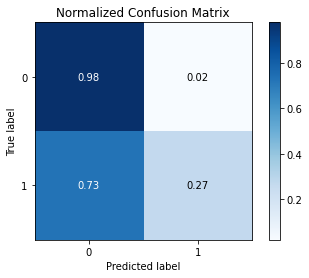

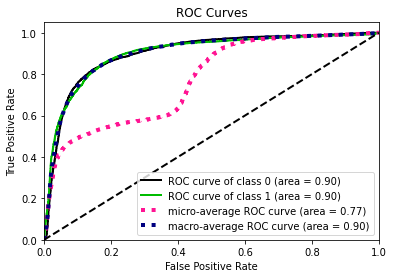

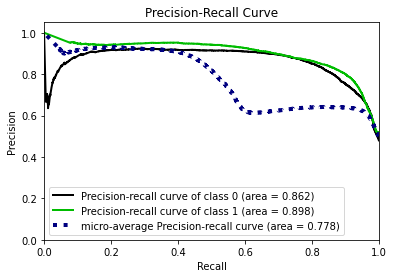

In [36]:
precisionNB = precision_score(trueResult, predictedNB)
recallNB = recall_score(trueResult, predictedNB)
fmeasureNB = f1_score(trueResult, predictedNB)
fprNB, tprNB, thresholdsNB = roc_curve(trueResult, predictedNB)
rocNB = metrics.roc_auc_score(trueResult, predictedNB)
print("Precision: %0.4f" % precisionNB)
print("Recall: %0.4f" % recallNB)
print("F-mesure: %0.4f" % fmeasureNB)
print("Surface sous la courbe ROC: %0.4f" % rocNB)
skplt.metrics.plot_confusion_matrix(trueResult, predictedNB, normalize=True)
skplt.metrics.plot_roc(trueResult, probasNB)
skplt.metrics.plot_precision_recall(trueResult, probasNB)

In [37]:
print(trueResult.shape)

(11969,)


### Comparaison des performances



Dans le rapport :D